In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn

In [2]:
model_name = 'models/xgboost_first_model.json'
xgb_model1 = xgb.XGBClassifier()
xgb_model1.load_model(model_name)
model_name = 'models/xgboost_second_model.json'
xgb_model2 = xgb.XGBClassifier()
xgb_model2.load_model(model_name)
model_name = 'models/xgboost_third_model.json'
xgb_model3 = xgb.XGBClassifier()
xgb_model3.load_model(model_name)

In [3]:
m3_pred = []
m2_pred = []
m1_pred = []
bird_list = []
year_list = []
dur_list = []
tim_list = []
fil_list = []
aug_list = []

for year in [2022,2023,2024,2025]:
# for year in [2022,2023,2024]:
    print(year)
    birds = os.listdir(f'/mnt/d/acoustics-data/birdclef-{year}/train_audio')
    for bird in birds:
        file = f'/mnt/d/acoustics-data/processed/birdclef-{year}/{bird}_features.npy'
        try:
            X = np.load(file,)
            n = X.shape[0]
            bird_list += [bird for _ in range(n)]
            year_list += [year for _ in range(n)]
            y_pred_proba = xgb_model1.predict_proba(X)[:,1]
            m1_pred += list(y_pred_proba)
            y_pred_proba = xgb_model2.predict_proba(X)[:,1]
            m2_pred += list(y_pred_proba)
            y_pred_proba = xgb_model3.predict_proba(X)[:,1]
            m3_pred += list(y_pred_proba)
            tab = pd.read_csv(f'/mnt/d/acoustics-data/processed/birdclef-{year}/{bird}_slices.csv')
            dur_list += tab['duration'].tolist()
            tim_list += tab['start_time'].tolist()
            fil_list += tab['file_name'].tolist()
            aug_list += tab['is_augmented'].tolist()
        except:
            pass

2022
2023
2024
2025


In [4]:
D = dict()
D['bird'] = bird_list
D['year'] = year_list
D['model_1'] = m1_pred
D['model_2'] = m2_pred
D['model_3'] = m3_pred
D['duration'] = dur_list
D['time'] = tim_list
D['file_name'] = fil_list
D['is_augmented'] = aug_list
df = pd.DataFrame(D)
df.head()

bird  year   model_1   model_2   model_3  duration  time     file_name  \
0  afrsil1  2022  0.520478  0.992990  0.997792    3.5004   0.0  XC207432.ogg   
1  afrsil1  2022  0.512172  0.992990  0.998557    3.5004   0.0  XC207432.ogg   
2  afrsil1  2022  0.374894  0.985676  0.996787    3.5004   0.0  XC207432.ogg   
3  afrsil1  2022  0.348209  0.987380  0.994968    3.5004   0.0  XC207432.ogg   
4  afrsil1  2022  0.469575  0.984070  0.995817    3.5004   0.0  XC207432.ogg   

   is_augmented  
0             0  
1             1  
2             1  
3             1  
4             1

In [5]:
# for 2022, 2023, 2024 data
ebird = pd.read_csv('/mnt/d/acoustics-data/birdclef-2022/eBird_Taxonomy_v2021.csv')
ebird = ebird[['SPECIES_CODE','ORDER1']]
ebird.columns = ['bird','order']
df = df.merge(ebird, on='bird', how='left')

In [6]:
# for 2025 included
nonbird = df[df['order'].isna()]
nonbird = nonbird[nonbird.columns[:8]]
taxo = pd.read_csv('/mnt/d/acoustics-data/birdclef-2025/taxonomy.csv')
taxo = taxo[['primary_label','class_name']]
taxo.columns = ['bird','order']
nonbird = nonbird.merge(taxo, on='bird', how='left')
nonnonbird = df[df['order'].notna()]
df = pd.concat((nonnonbird,nonbird))
del nonnonbird
del nonbird

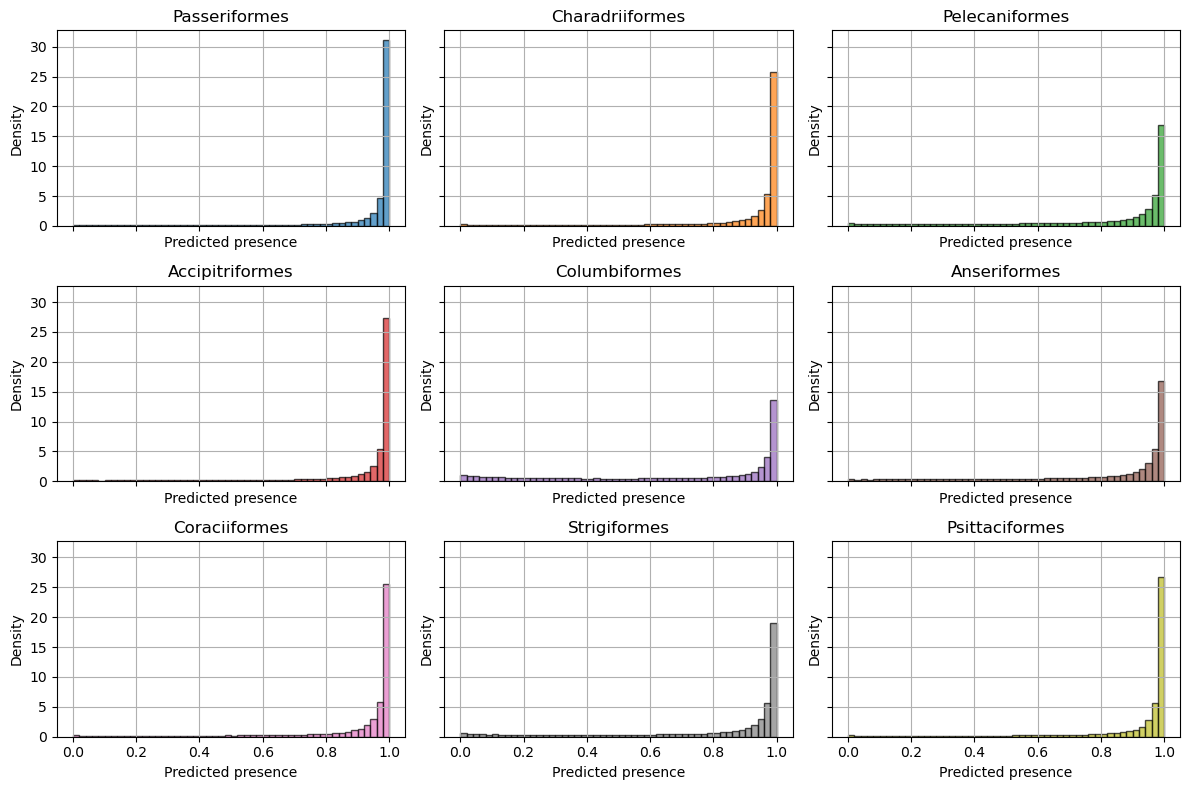

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()

axes = axes.flatten()

uniq_classes = df['order'].value_counts().index.tolist()

classes = uniq_classes[0:9]

colors = ['tab:blue', 'tab:orange', 'tab:green', 
          'tab:red', 'tab:purple', 'tab:brown',
          'tab:pink', 'tab:gray', 'tab:olive']

for i, clss in enumerate(classes):
    x = df[(df['order'] == clss)].model_3
    axes[i].hist(x, 50, edgecolor='k', density=True, alpha=0.7, color=colors[i])
    axes[i].set_title(clss)
    axes[i].set_xlabel('Predicted presence')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.tight_layout()
plt.savefig('xgboost_third_model_orders_1_9.png')
plt.show()

In [23]:
df[df['model_3']>0.9].shape[0] / df.shape[0]

0.7374329893469489